In [1]:
import pandas as pd
import numpy as np
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import defaultdict
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
from sklearn import metrics

## Read the Datasets

In [2]:
df=pd.read_json(r"./../../Dataset/Sarcasm_Headlines_Dataset_v2/Sarcasm_Headlines_Dataset_v2.json",lines=True)

In [3]:
df.shape

(28619, 3)

In [4]:
df.columns

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')

In [5]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [6]:
#Check for any null values int the dataset
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
# Check for any duplicate rows

In [8]:
df['article_link'].nunique()

28617

In [9]:
#There are 2 duplicate rows
df.duplicated().sum()

2

In [10]:
#Remove duplicate rows
df.drop_duplicates(keep='first', inplace=True)

In [11]:
#No duplicated found
df.duplicated().sum()

0

## Data Cleaning

## Step 1:
### Remove Special Characters
### Check if numbers are required
### Remove anomalies like 1a 2b

In [12]:
%%time
df1=df.copy()

#Remove all single letter words
df1['headline']=df1['headline'].apply(lambda x: re.sub(r"[^\w\s]"," ",str(x)))

#Remove all numbers
df1['headline']=df1['headline'].apply(lambda x: re.sub(r'\d',"",str(x)))

#Remove word anomalies
df1['headline']=df1['headline'].apply(lambda x: re.sub(r'\d{1}[a-z]',"",str(x)))

#Remove extra spaces
df1['headline']=df1['headline'].apply(lambda x: " ".join(x.split()))

Wall time: 263 ms


## Step 2:
### Convert to lower case
### Remove Stopwords and special words that need to be removed
### Perform Lemmatization
### Remove all single letter words
### Remove extra spaces

In [13]:
%%time
stop=set(stopwords.words('english'))
#Update any words that we want to remove here
custom_list=['nan']
stop.update(custom_list)

tadDict = defaultdict(lambda : wn.NOUN)
tadDict['J'] = wn.ADJ
tadDict['V'] = wn.VERB
tadDict['R'] = wn.ADV

#Convert to lower case
df1['headline']=df1['headline'].apply(lambda x: x.lower())

#Remove stopwords
df1['headline']=df1['headline'].apply(lambda x: " ".join([i for i in word_tokenize(x) if i.casefold() not in map(str.casefold,stop)]))

#Perform Lemmatization
df1['headline']=df1['headline'].apply(lambda x: " ".join(WordNetLemmatizer().lemmatize(word,tadDict[tag[0]]) for word,tag in pos_tag(word_tokenize(x))))

#Remove all single letter words
df1['headline']=df1['headline'].apply(lambda x: re.sub(r"( [a-z]{1} )|(^[a-z]{1} )|( [a-z]{1}$)"," ",str(x)))

#Remove extra spaces
df1['headline']=df1['headline'].apply(lambda x: " ".join(x.split()))

Wall time: 51.1 s


In [14]:
df_cleaned=df1.copy()

In [15]:
df_cleaned_sarcastic=df_cleaned[df_cleaned['is_sarcastic']==1]
df_cleaned_non_sarcastic=df_cleaned[df_cleaned['is_sarcastic']==0]

In [16]:
from collections import Counter
corpus_sarcastic=" ".join(df_cleaned_sarcastic['headline'])
corpus_split=corpus_sarcastic.split()
Counter=Counter(corpus_split)
most_occur = Counter.most_common(10)
most_occur

[('man', 1288),
 ('new', 1010),
 ('report', 581),
 ('get', 544),
 ('area', 493),
 ('woman', 487),
 ('year', 473),
 ('nation', 391),
 ('trump', 385),
 ('go', 373)]

In [17]:
from collections import Counter
corpus_non_sarcastic=" ".join(df_cleaned_non_sarcastic['headline'])
corpus_split=corpus_non_sarcastic.split()
Counter=Counter(corpus_split)
most_occur = Counter.most_common(10)
most_occur

[('trump', 1450),
 ('new', 686),
 ('say', 546),
 ('woman', 479),
 ('make', 465),
 ('get', 464),
 ('donald', 458),
 ('year', 381),
 ('one', 272),
 ('day', 269)]

### Create Word Embeddings using TF-IDF

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD

In [19]:
#TF-IDF Vecctorizer
def tfidf(data, ma = 0.6, mi = 0.0001):
    tfidf_vectorize = TfidfVectorizer(ngram_range=(1,2),max_df = ma, min_df = mi)
    tfidf_data = tfidf_vectorize.fit_transform(data)
    return tfidf_data

In [20]:
headline=df_cleaned['headline']
is_sarcastic=df_cleaned['is_sarcastic']

In [21]:
%%time
#feature extraction
training = tfidf(headline)
training.shape

Wall time: 711 ms


(28617, 13904)

## Creating Test Training Split

In [22]:
#training and test data splits
x_train, x_test, y_train, y_test = train_test_split(training, is_sarcastic, test_size = 0.25, random_state = 0)

In [23]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(21462, 13904)
(7155, 13904)
(21462,)
(7155,)


# Classification Task

## Naive Bayes classifier

In [24]:
#Naive Bayes classifier
def test_NaiveBayes(x_train, x_test, y_train, y_test):
    MNB = MultinomialNB()
    NBClassifier = MNB.fit(x_train, y_train)
    predictions = NBClassifier.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [25]:
%%time
#Tesiting Naive-Bayes classifier
accuracy, precision, recall, f1 = test_NaiveBayes(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.7921733053808525
Precision= 0.7922050061061539
Recall   = 0.7921733053808525
F1 Score = 0.7918528508079133
Wall time: 16 ms


## Logistic Regression Classifier

In [26]:
from sklearn.linear_model import LogisticRegression
def test_LogisticRegression(x_train, x_test, y_train, y_test):
    model = LogisticRegression(class_weight='balanced',solver="liblinear",max_iter=300, C=1e1)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [27]:
%%time
#Tesiting Logistic Regression classifier
accuracy, precision, recall, f1 = test_LogisticRegression(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.7917540181691125
Precision= 0.7916698708207639
Recall   = 0.7917540181691125
F1 Score = 0.791691856768665
Wall time: 121 ms


## Multilayer Perceptron classfier

In [28]:
#Multilayer Perceptron classfier
def test_NN(x_train, x_test, y_train, y_test):
    NN = MLPClassifier(solver = 'lbfgs', alpha = 0.00095, learning_rate = 'adaptive', learning_rate_init = 0.01, max_iter = 500, random_state = 0)
    Perceptron = NN.fit(x_train, y_train)
    predictions = Perceptron.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [29]:
%%time
#Testing NN classifier
accuracy, precision, recall, f1 = test_NN(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.7554157931516422
Precision= 0.7564586830513308
Recall   = 0.7554157931516422
F1 Score = 0.755587404724102
Wall time: 1min 44s


In [30]:
#Multilayer Perceptron classfier
def test_NN(x_train, x_test, y_train, y_test):
    NN = MLPClassifier(hidden_layer_sizes=(100 ),solver = 'adam', alpha = 0.00095, learning_rate = 'adaptive', learning_rate_init = 0.01, max_iter = 300, random_state = 0)
    Perceptron = NN.fit(x_train, y_train)
    predictions = Perceptron.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [31]:
%%time
#Testing NN classifier
accuracy, precision, recall, f1 = test_NN(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.772606568832984
Precision= 0.7725983369191954
Recall   = 0.772606568832984
F1 Score = 0.772218700068653
Wall time: 9min 42s


## SVM classifier

In [32]:
#SVM classifier
def test_SVM(x_train, x_test, y_train, y_test):
    SVM = SVC(kernel = 'linear')
    SVMClassifier = SVM.fit(x_train, y_train)
    predictions = SVMClassifier.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r,f

In [33]:
%%time
#Testing SVM classifier
accuracy, precision, recall, f1 = test_SVM(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.7956673654786862
Precision= 0.7956392835566763
Recall   = 0.7956673654786862
F1 Score = 0.7954131617707294
Wall time: 57.8 s


## Extreme Learning Machine (ELM)

In [34]:
%%time
input_size = x_train.shape[1]
hidden_size = 2000
input_weights = np.random.uniform(low=0, high=1,size=[input_size,hidden_size])
biases = np.random.uniform(low=0, high=1,size=[hidden_size])

def relu(x):
    return np.maximum(x, 0, x)

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

output_weights = np.dot(np.linalg.pinv(hidden_nodes(x_train.A)), y_train)
prediction = predict(x_test.A)
# Applying Sigmoidal Activation function
y_pred=[1/(1+np.exp(-x)) for x in prediction]

Wall time: 44.6 s


In [35]:
acc=[]
prec=[]
rec=[]
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]:
    y_pred=[1 if x>=i else 0 for x in prediction]
    acc.append(metrics.accuracy_score(y_test, y_pred))
    prec.append(metrics.precision_score(y_test, y_pred))
    rec.append(metrics.recall_score(y_test, y_pred))

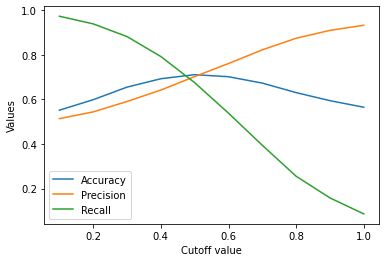

In [40]:
plt.plot(np.arange(0.1,1.1,0.1),acc,label="Accuracy")
plt.plot(np.arange(0.1,1.1,0.1),prec,label="Precision")
plt.plot(np.arange(0.1,1.1,0.1),rec,label="Recall")
plt.xlabel('Cutoff value')
plt.ylabel('Values')
plt.legend()
plt.show()

In [37]:
y_pred=[1 if x>=0.5 else 0 for x in prediction]

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

# Model F1-Score
print("F1-Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.7109713487071978
Precision: 0.7023370233702337
Recall: 0.6749408983451537
F1-Score: 0.6883664858348403
